# 在NVIDIA L20上使用FSDP和QLora微调Llama 3 70B模型


Meta最近发布了Llama 3模型，展现了强大的性能，Llama 3的亮点包括：

1. 首次出现8B模型，且8B模型与70B模型全系列使用GQA(Group Query Attention)。
2. 最大模型达到400B规模大小，未来几个月内发布！
3. 分词器由SentencePiece换为了Tiktoken，与GPT4保持一致。
4. 相比于Llama2 的32000词表大小，Llama3的词表大小来到了惊人的128256。
5. 数据方面上，Llama3使用了约15T token用于模型的训练。
6. 开源模型大小为8B和70B两种，每种规模均有开源基座模型和instruct模型。
7. Llama3 8B Instruct模型在数学与代码能力方面数倍于Llama2 7B chat模型。

然而大多数时候，我们需要根据数据微调这些模型，以释放模型的全部潜力。因此我们使用FSDP和QLora技术来微调Llama 3 70B模型

* **FSDP：将训练扩展到多个GPU**
  
  一个70B参数的模型需要140GB的显存，通过FSDP，我们将Llama 3 70B模型分布在4张L20组成的192 GB显存上，满足了高效训练的要求。
  
* **QLoRA：在单个GPU上训练更大的模型**
  
  QLoRA是现代神经网络中两个至关重要的进步的简单而出色的组合：量化和LoRA，QLoRA的开发团队在48GB的GPU卡上成功的训练了65B参数的模型（未量化需要130GB显存）。

本次测试，我们使用了NVIDIA在国内可以合规获得的L20服务器，服务器配置如下，如果您对L20感兴趣，请与我们联系

![](2024-04-24-14-42-06.png)

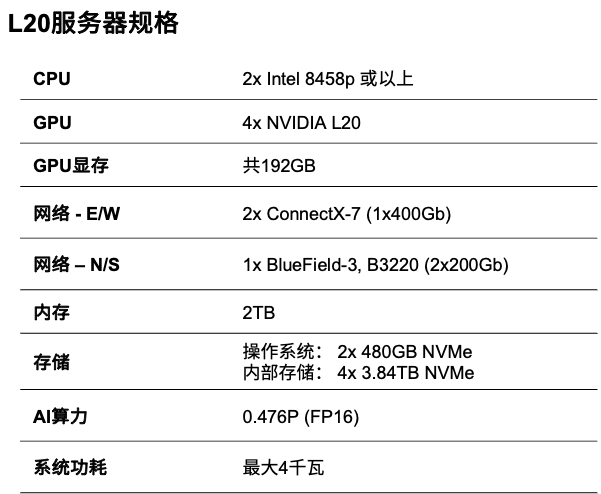

## 1. 搭建开发环境

我们的第一步是安装Hugging Face库和PyTorch，包括trl、transformers和datasets。如果你还没有听说过trl，不用担心。它是建立在 transformers和datasets之上的一个新库，可以更方便地进行微调、rlhf、对齐开放的大型语言模型（LLMs）。 

In [ ]:
# 使用conda先构建一个Python-3.10的虚拟环境
%conda create --name llama3 python=3.10 -y
%conda activate llama3

# 安装Pytorch for FSDP和FA/SDPA
%pip install "torch==2.2.2" tensorboard

# 安装Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0" 

接下来我们需要登录Hugging Face来访问Llama 3 70b模型。如果您还没有帐户并接受条款，您可以[此处](https://huggingface.co/join)在创建一个. 

In [ ]:
# Log in using a token from huggingface.co/settings/tokens
%huggingface-cli login --token ""

接下来我们安装trl和Peft

In [ ]:
# 从github上安装trl & peft
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple  git+https://github.com/huggingface/trl.git
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple  git+https://github.com/huggingface/peft.git

如果您使用的是Ampere架构或更新的GPU，则可以使用Flash Attention。Flash Attention是一种对注意力计算进行重新排序的方法，它利用经典技术（平铺、重新计算）显著加快计算速度，并将内存使用量从序列长度的二次方降低到线性。简而言之，就是将训练速度提高3倍。

In [ ]:
import torch

# 检查GPU是否支持Flash Attention
assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'

# 安装flash-attn所需的依赖项
print("Installing dependencies...")
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple ninja packaging

# 安装flash-attn，使用4个并行作业并禁用构建隔离
print("Installing flash-attn...")
%MAX_JOBS=4 pip install -i https://pypi.tuna.tsinghua.edu.cn/simple flash-attn --no-build-isolation

## 2. 创建和准备数据集

开发环境设置好后，我们可以开始创建和准备数据集，我们就需要创建一个数据集来微调我们的模型。这个数据集应该是你想要解决的任务的各种演示，有多种方法可以创建这样的数据集：

1. 使用现有的开放源码数据集，如Spider
2. 使用LLMs创建合成数据集，如Alpaca
3. 利用人类创建数据集，如Dolly
4. 综合使用上述方法，如Orca

每种方法都有自己的优缺点，并取决于预算、时间和质量要求。例如，使用现有的数据集是最简单的，但可能不适合您的具体使用情况；而使用人类可能是最准确的，但可能耗时且昂贵。也可以将几种方法结合起来创建一个指令数据集。 

在我们的示例中，我们将使用一个名为sql-create-context的现有数据集，其中包含自然语言指令、模式定义和相应SQL查询的样本。随着trl的最新发布，我们现在支持流行的指令和对话数据集格式。这意味着我们只需将数据集转换为其中一种受支持的格式， trl就会处理剩下的工作。这些格式包括：

* Conversational format 对话形式
* Instruction format 指令格式

在我们的示例中，我们将使用数据集库加载开源数据集，然后将其转换为对话格式，在系统消息中为助手加入模式定义。然后，我们会将数据集保存为jsonl文件，然后用它来微调我们的模型。我们将随机对数据集进行下采样，仅保留10,000个样本。




In [ ]:
# SQL Query translator
# 将代码保存为Python文件，例如data_processing.py
# 在终端中，进入代码所在的目录，并执行以下命令:python data_processing.py

from datasets import load_dataset

# Convert dataset to OAI messages
system_message = """You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA.
SCHEMA:
{schema}"""

def create_conversation(sample):
  return {
    "messages": [
      {"role": "system", "content": system_message.format(schema=sample["context"])},
      {"role": "user", "content": sample["question"]},
      {"role": "assistant", "content": sample["answer"]}
    ]
  }

# Load dataset from the hub
dataset = load_dataset("b-mc2/sql-create-context", split="train")
dataset = dataset.shuffle().select(range(12500))

# Convert dataset to OAI messages
dataset = dataset.map(create_conversation, remove_columns=dataset.features,batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
dataset = dataset.train_test_split(test_size=2500/12500)

print(dataset["train"][345]["messages"])

# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")


我们将使用 HuggingFaceH4/noo_robots 数据集，这是一个由熟练的人类注释者创建的高质量数据集，包含 10,000 个指令和演示。该数据可用于监督微调（SFT），使语言模型更好地遵循指令。No Robots 以 OpenAI 的 InstructGPT 论文中描述的指令数据集为模型，主要由单转指令组成。

no_robots 数据集有 10,000 个示例，分为 9,500 个训练示例和 500 个测试示例。有些示例不包含 system 消息。我们将使用 datasets 库加载数据集，添加缺失的 system 消息，并将它们保存到单独的 json 文件中。

In [ ]:
# Llama 3
# 将以代码保存为Python文件，例如 data_processing.py
# 在终端中，进入代码所在的目录，并执行以下命令:python data_processing.py
from datasets import load_dataset

# Convert dataset to OAI messages
system_message = """You are Llama, an AI assistant created by Philipp to be helpful and honest. Your knowledge spans a wide range of topics, allowing you to engage in substantive conversations and provide analysis on complex subjects."""

def create_conversation(sample):
    if sample["messages"][0]["role"] == "system":
        return sample
    else:
      sample["messages"] = [{"role": "system", "content": system_message}] + sample["messages"]
      return sample

# Load dataset from the hub
dataset = load_dataset("HuggingFaceH4/no_robots")

# Add system message to each conversation
columns_to_remove = list(dataset["train"].features)
columns_to_remove.remove("messages")
dataset = dataset.map(create_conversation, remove_columns=columns_to_remove,batched=False)

# Filter out conversations which are corrupted with wrong turns, keep which have even number of turns after adding system message
dataset["train"] = dataset["train"].filter(lambda x: len(x["messages"][1:]) % 2 == 0)
dataset["test"] = dataset["test"].filter(lambda x: len(x["messages"][1:]) % 2 == 0)

# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records", force_ascii=False)
dataset["test"].to_json("test_dataset.json", orient="records", force_ascii=False)


## 3. 使用 PyTorch FSDP、QLora 和 SDPA 对 LLM 进行微调

现在，我们准备使用 PyTorch FSDP、QLora和SDPA对模型进行微调。由于我们采用的是分布式设置，因此需要使用torchrun和python脚本来启动训练。

我们编写了run_fsdp_qlora.py脚本，它将从磁盘加载数据集、准备模型、标记符并开始训练。它使用trl中的SFTTrainer来微调我们的模型。 SFTTrainer可以直接监督微调打开LLMs支持：

* 数据集格式，包括会话和指令格式（✅已使用）
* 只对完成情况进行培训，忽略提示（❌ 未使用）
* 打包数据集，提高训练效率（✅已使用）
* 支持 PEFT（参数效率微调），包括 QLoRA（✅ 已使用）
* 为会话微调准备模型和标记符（❌ 未使用，见下文）

在配置方面，我们使用了新的TrlParser ，它允许我们在yaml文件中提供超参数，或者通过明确地将参数传递给CLI来覆盖配置文件中的参数，例如 --num_epochs 10。以下是在 4xL20 GPU上微调 Llama 3 70B的配置文件。

In [ ]:
%%writefile llama_3_70b_fsdp_qlora.yaml
# script parameters
# model_id: "meta-llama/Meta-Llama-3-70b" # Hugging Face model id,从网上下载模型
model_id: "/home/user01/LLM/models/Meta-Llama-3-70B-Instruct" # Local path to the model，使用本地已经下载的模型
dataset_path: "."                      # path to dataset
max_seq_len:  3072 # 2048              # max sequence length for model and packing of the dataset
# training parameters
output_dir: "./llama-3-70b-hf-no-robot" # Temporary output directory for model checkpoints
report_to: "tensorboard"               # report metrics to tensorboard
learning_rate: 0.0002                  # learning rate 2e-4
lr_scheduler_type: "constant"          # learning rate scheduler
num_train_epochs: 3                    # number of training epochs
per_device_train_batch_size: 1         # batch size per device during training
per_device_eval_batch_size: 1          # batch size for evaluation
gradient_accumulation_steps: 2         # number of steps before performing a backward/update pass
optim: adamw_torch                     # use torch adamw optimizer
logging_steps: 10                      # log every 10 steps
save_strategy: epoch                   # save checkpoint every epoch
evaluation_strategy: epoch             # evaluate every epoch
max_grad_norm: 0.3                     # max gradient norm
warmup_ratio: 0.03                     # warmup ratio
bf16: true                             # use bfloat16 precision
tf32: true                             # use tf32 precision
gradient_checkpointing: true           # use gradient checkpointing to save memory
# FSDP parameters: https://huggingface.co/docs/transformers/main/en/fsdp
fsdp: "full_shard auto_wrap offload" # remove offload if enough GPU memory
fsdp_config:
  backward_prefetch: "backward_pre"
  forward_prefetch: "false"
  use_orig_params: "false"


*注：训练结束时，GPU 内存使用量会略有增加（约 10%）。这是因为要正确保存模型。请确保 GPU 上有足够的内存来保存模型。*

为了启动训练，我们将使用torchrun以保持示例的灵活性和易于调整，例如 Amazon SageMaker 或 Google Cloud Vertex AI。对于 torchrun 和 FSDP，我们需要设置环境变量 ACCELERATE_USE_FSDP 和 FSDP_CPU_RAM_EFFICIENT_LOADING 以告诉 transformers/accelerate 使用 FSDP，并以节省内存的方式加载模型。

*注意：要注意 CPU 卸载，您需要更改 fsdp 的值并移除 offload 。这仅适用于 > 40GB GPU，因为它需要更多内存。*

未启动训练之前，当前L20 GPU卡的状态如下图：

![](2024-04-23-22-16-29.png)

现在，让我们用以下命令启动训练：

In [ ]:
%ACCELERATE_USE_FSDP=1 FSDP_CPU_RAM_EFFICIENT_LOADING=1 torchrun --nproc_per_node=4 ./scripts/run_fsdp_qlora.py --config llama_3_70b_fsdp_qlora.yaml

训练开始后，显示如下：


![](2024-04-24-07-05-02.png)

运行watch -n 1 nvidia-smi命令，可以实时监控GPU的使用情况


![](2024-04-24-07-11-04.png)



![](2024-04-24-07-43-07.png)

训练运行时间：

23:01:31 第一次运行

23:18:46 中断一次，keboard原因

23:18:47 从checkpoint重新开始

23:46:00 结束

训练结束后，GPU运行状如下：

![](2024-04-24-07-49-34.png)

预期内存使用量：

* 使用 FSDP 进行全面微调需要 ~16X80GB GPU
* FSDP + LoRA 需要 ~8X80GB GPU
* FSDP + Q-Lora 需要 ~2x40GB GPU
* FSDP + Q-Lora + CPU 卸载需要 4x24GB GPU，每个 GPU 22 GB，CPU RAM 127 GB，序列长度为 3072，批处理大小为 1。

使用 Flash Attention 对 Llama 3 70B 使用 10k 样本数据集进行 3 个 epoch 的训练需要 45 小时g5.12xlarge。实例成本5.67$/h将导致总成本为255.15$。这听起来很昂贵，但允许您在较小的 GPU 资源上微调 Llama 3 70B。如果我们将训练规模扩大到 4 个 H100 GPU，训练时间将减少到约 1.25 小时。如果我们假设 1x H100 成本，5-10$/h则总成本将在25$-50$.

我们可以看到可访问性和性能之间的权衡。如果您可以获得更多/更好的计算，您可以减少训练时间和成本，但即使资源很少，您也可以对 Llama 3 70B 进行微调。成本/性能有所不同，因为对于 4x A10G GPU，我们需要将模型卸载到 CPU，从而减少总体失败次数。